# 2D tdem inversion results

In [1]:
import SimPEG.EM.TDEM as tdem
from SimPEG import Utils,Maps
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pymatsolver import Pardiso
%matplotlib inline
from discretize import TensorMesh

In [2]:
import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['image.cmap'] = 'rainbow'

## Load Mesh

In [3]:
datadir = 'TEM_data'

#datadir = None
mesh_3d = TensorMesh.readUBC(datadir+'/mesh_3d.msh')
actind = np.load(datadir+'/actind_2d.npy')
locs = np.load(datadir+'/locs.npy')
time = np.load(datadir+'/times.npy')
dobs = np.load(datadir+'/dobs.npy')
x = locs[:,0]
mesh_2d = TensorMesh([mesh_3d.hx,mesh_3d.hz],x0=[mesh_3d.x0[0],mesh_3d.x0[2]])

In [4]:
map_2Dto3D = Maps.Surject2Dto3D(mesh_3d)
expmap = Maps.ExpMap(mesh_2d)
actmap = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.log(3))
actmap_plot = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.nan)
mapping = map_2Dto3D * expmap * actmap
mapping_plot = map_2Dto3D * expmap * actmap_plot

## load observation

In [6]:
datadir = 'TEMinversion_result./'
import os
model = []
for File in sorted(os.listdir(datadir)):
    if File.endswith("14.npy"):
        model.append(np.load(datadir+File))

In [7]:
def plot_model(iteration):
    fig, ax = plt.subplots(1, 1)
    #fig.dpi =300
    sigma= expmap * actmap * model[iteration]
    out = mesh_2d.plotImage(sigma, ax=ax,
                            grid = True,
                            gridOpts={'alpha':0.8,'c':'gray','linewidth':0.5},
                            pcolorOpts={'norm':LogNorm()},
                            #clim=[1e-3,1e8]
                           ) 
    # ax.plot(xy_box[:,0], xy_box[:,1], 'w--')
    cb = plt.colorbar(out[0], fraction=0.025, ax=ax)

    ax.set_ylim(-3800, -3500)
    ax.set_aspect(1)
    ax.set_xlim(x.min(),x.max())
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Depth(m)')
    cb.set_label('Conductivity (S/m)')
    ax.set_title(("Iteration %i")%(iteration+1), fontsize = 17)
    plt.show()
from ipywidgets import interact, IntSlider
interact(plot_model, iteration = IntSlider(min=0, max=(len(model)-1)))

interactive(children=(IntSlider(value=0, description='iteration', max=14), Output()), _dom_classes=('widget-in…

<function __main__.plot_model(iteration)>

In [10]:
nSrc = x.shape[0]
dpred = np.load(datadir+'dpred.npy')
mopt= np.load(datadir+'mopt.npy')
results = np.loadtxt(datadir+'InversionModel-2022-09-17-17-14.txt')
DPRED = dpred.reshape((nSrc, time.size))
DOBS  = dobs.reshape((nSrc,time.size))
sigma = expmap * actmap * model[-1]

C:\Users\NEIL\anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


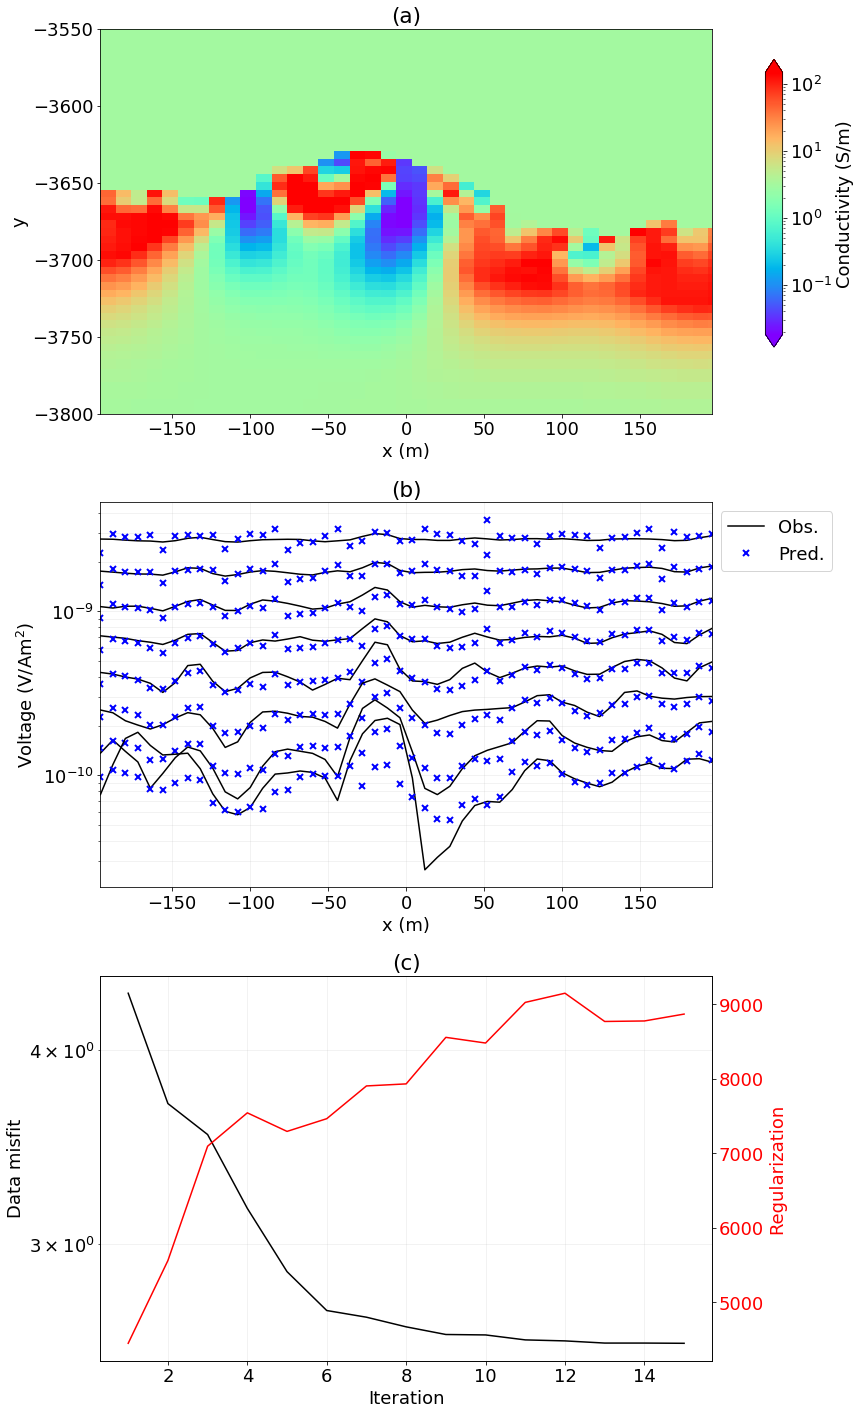

In [11]:
#clim=[0.01,1e2]

zlim = [-3800, -3550]
fig, ax = plt.subplots(3, 1, figsize=(12, 10*2))
out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, ax=ax[0])
position=fig.add_axes([0.90, 0.75, 0.02, 0.2])
cb = plt.colorbar(out[0], fraction= 0.025, extend="both",cax = position)
ax[0].set_xlabel("x (m)")
ax[0].set_xlim(x.min(), x.max())  
ax[0].set_ylim(zlim)  

cb.set_label('Conductivity (S/m)')
ax[0].set_title("(a)")

for itime in range(time.size):
    ax[1].semilogy(x, -DOBS[:,itime], 'k-')
    ax[1].semilogy(x, -DPRED[:,itime], 'bx', markeredgewidth=2)
ax[1].set_xlim(x.min(), x.max())    
ax[1].legend(("Obs.", "Pred."), bbox_to_anchor=(1,1))
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("Voltage (V/Am$^2$)")
ax[1].grid(which="both", alpha=0.2)
ax[1].set_title("(b)")

ax_1 = ax[2].twinx()
ax[2].semilogy(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'k-')
ax_1.plot(results[:,0], results[:,3], 'r-')
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Data misfit")
ax_1.set_ylabel("Regularization", color='red')
for tl in ax_1.get_yticklabels():
    tl.set_color('r')
ax[2].grid(which='both', alpha=0.2)
ax[2].set_title("(c)")


plt.tight_layout()
#fig.savefig('inversion.png', dpi=350, bbox_inches="tight")

Text(3e-11, 2.8e-09, 'b.')

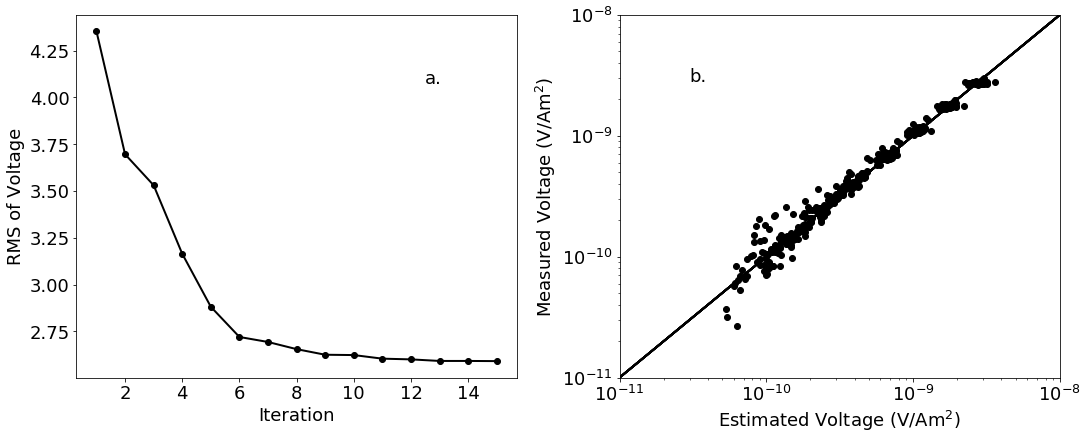

In [12]:
#clim=[0.01,1e2]

fig, ax = plt.subplots(1, 2, figsize=(15, 3*2),sharex=False,sharey=False,constrained_layout=True)

ax[0].plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'ko',linewidth=2)
ax[0].plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'k',linewidth=2)

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel('RMS of Voltage')

for tl in ax_1.get_yticklabels():
    tl.set_color('r')
#ax[0].grid(which='both', alpha=0.2)
ax[0].text(12.5,4.075,'a.')

for itime in range(time.size):
    ax[1].loglog(-DPRED[:,itime], -DOBS[:,itime], 'ko',linewidth=2)
    ax[1].loglog([1e-11,1e-8],[1e-11,1e-8], 'k-', linewidth=2)
ax[1].set_xlim(1e-11,1e-8)  
ax[1].set_ylim(1e-11,1e-8) 
ax[1].set_xlabel('Estimated Voltage (V/Am$^2$)')
ax[1].set_ylabel('Measured Voltage (V/Am$^2$)')
#ax[1].grid(which="both", alpha=0.2)
ax[1].text(3e-11,2.8e-9,'b.')

#plt.tight_layout()
#fig.savefig('convergence.png', dpi=350, bbox_inches="tight")

In [16]:
np.save(datadir+'results', results)
np.save(datadir+'DPRED', DPRED)
np.save(datadir+'DOBS', DOBS)

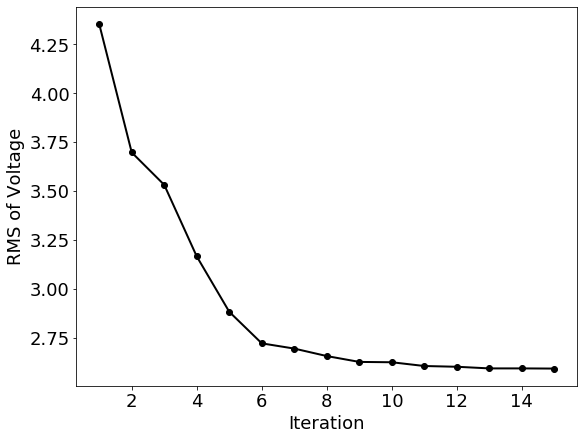

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6),sharex=False,sharey=False,constrained_layout=True)

ax.plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'ko',linewidth=2)
ax.plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'k',linewidth=2)

ax.set_xlabel("Iteration")
ax.set_ylabel('RMS of Voltage')

for tl in ax_1.get_yticklabels():
    tl.set_color('r')
#ax[0].grid(which='both', alpha=0.2)
#ax.text(20,7.0,'a.')

#fig.savefig('convergencetem01.png', dpi=600, bbox_inches="tight")

Text(1.5e-11, 5e-09, 'b.')

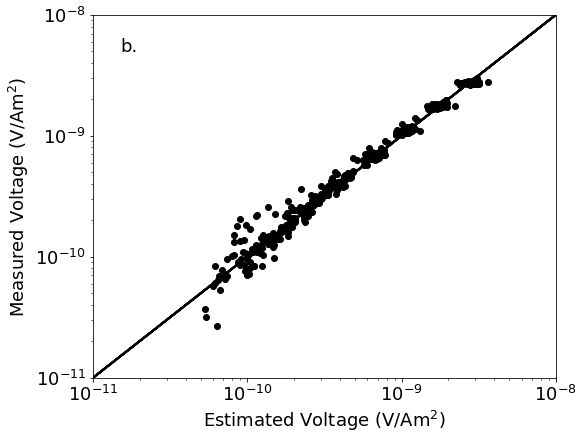

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6),sharex=False,sharey=False,constrained_layout=True)
for itime in range(time.size):
    ax.loglog(-DPRED[:,itime], -DOBS[:,itime], 'ko',linewidth=2)
    ax.loglog([1e-11,1e-8],[1e-11,1e-8], 'k-', linewidth=2)
ax.set_xlim(1e-11,1e-8)  
ax.set_ylim(1e-11,1e-8) 
ax.set_xlabel('Estimated Voltage (V/Am$^2$)')
ax.set_ylabel('Measured Voltage (V/Am$^2$)')
#ax[1].grid(which="both", alpha=0.2)
ax.text(1.5e-11,5e-9,'b.')

In [9]:
TD_model= np.c_[mesh_2d.gridCC,np.log(sigma)]
np.savetxt('TEM_inverted_model_value.csv',TD_model,delimiter = ',')